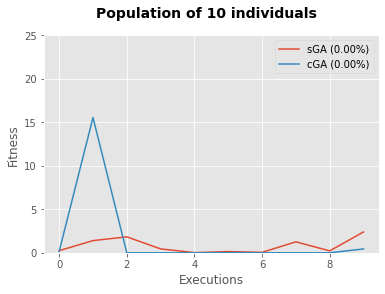

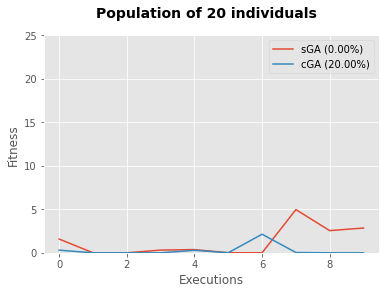

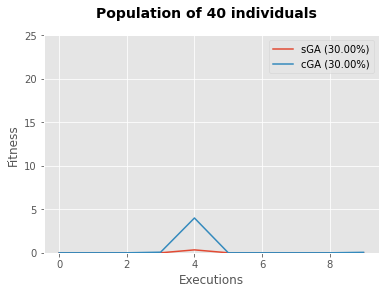

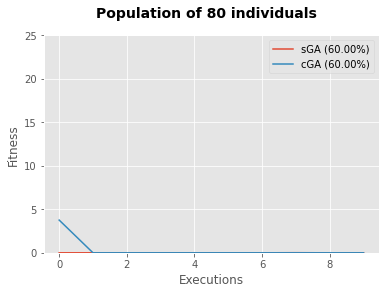

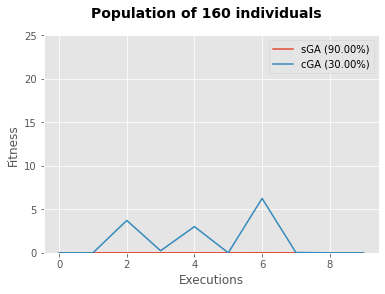

In [32]:
################################################################################
## Imports

import math
import random
import numpy
from pyeasyga import pyeasyga
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

################################################################################
## Common code

# Population sizes
sizes = [10, 20, 40, 80, 160]

# Number of tests
tests = 10

# Error
ERR = 1e-10

# Fitness of the global solution
global_fitness = 0

# Data
data = [0] * 5

# Define fitness function
def fitness_function(individual, data=None):
  sum = 0
  for u in individual:
    sum += (u ** 2)
  return sum

# Define the key field for sorting
def get_key(obj):
  return obj.fitness

def round_up(n, decimals=10):
  multiplier = 10 ** decimals
  return math.floor(n * multiplier) / multiplier

################################################################################
## Simple Genetic Algorithm (sGA)

# Best fitness of each execution
fitness_sga = []

# Create a new individual
def create_individual(data):
  # Set mutation range
  mrange = len(data)
  # Generate a random individual
  individual = []
  for d in data:
    individual.append(random.uniform(d - mrange, d + mrange))
  # Return a new individual
  return individual

# Fix mutate function
def mutate_function(individual):
  # Set mutation range
  mrange = max(individual)
  mutate_index = random.randrange(len(individual))
  d = individual[mutate_index]
  individual[mutate_index] = random.uniform(d - mrange, d + mrange)

# Fix population fitness calculation
def calculate_population_fitness(self):
  for individual in self.current_generation:
    individual.fitness = self.fitness_function(individual.genes, self.seed_data)
    individual.fitness = round_up(individual.fitness)
    individual.fitness = 0 if ERR >= individual.fitness else individual.fitness

# Set initial population generation function (fix rank population call)
def create_first_generation(self):
  self.create_initial_population()
  self.calculate_population_fitness(self)
  self.rank_population()

# Set next population generation function (fix rank population call)
def create_next_generation(self):
  self.create_new_population()
  self.calculate_population_fitness(self)
  self.rank_population()

# Set evolution function
def run(self):
  # Initialize seed data with random values
  model_size = len(self.seed_data)
  for i in range(model_size):
    self.seed_data[i] = random.uniform(-model_size, model_size)
  # Run evolution
  self.create_first_generation(self)
  for _ in range(1, self.generations):
    self.create_next_generation(self)
    fitness, _ = sga.best_individual()

for ps in sizes:
  popfit = []
  for _ in range(tests):
    # Initialize genetic algorithm
    sga = pyeasyga.GeneticAlgorithm(data, population_size=ps,
      maximise_fitness=False)
    # Update default functions
    sga.create_individual = create_individual
    sga.mutate_function = mutate_function
    sga.create_first_generation = create_first_generation
    sga.create_next_generation = create_next_generation
    sga.calculate_population_fitness = calculate_population_fitness
    sga.run = run
    # Set fitness function
    sga.fitness_function = fitness_function
    # Run sGA
    sga.run(sga)
    # Get best individual
    fitness, result = sga.best_individual()
    popfit.append(fitness)
  fitness_sga.append(popfit)

################################################################################
## Compact Genetic Algorithm (cGA)

# Best fitness of each execution
fitness_cga = []

# Generate probability vector
def generate_prob(model_size):
  prob = []
  std_stdev = 1
  for i in range(model_size):
    bound = model_size + std_stdev
    mean = random.uniform(-bound, bound)
    pair = (mean, std_stdev)
    prob.append(pair)
  return prob

# Update probability vector
def update_prob(population, prob):
  # Update probability vector with the best results
  for i in range(len(prob)):
    # Mean and standard deviation of the ith element
    aux = []
    for item in population:
      mean = item.genes[i]
      aux.append(mean)
    # Update mean and stdev
    prob[i] = numpy.mean(aux), numpy.std(aux, ddof=1)

# Create a new individual
def create_individual(prob):
  individual = []
  for p in prob:
    mean, stdev = p
    value = random.uniform(mean - stdev, mean + stdev)
    individual.append(value)
  mean = numpy.mean(individual)
  stdev = numpy.std(individual, ddof=1)
  individual = numpy.random.normal(mean, stdev, len(individual))
  # Return a new individual
  return pyeasyga.Chromosome(individual)

# Set evolution function
def run(self):
  # Initialize the max number of individuals in a offspring
  offspring_max = self.population_size
  # Initialize best solution
  best = None
  # Initialize best individuals population
  k = int(self.population_size / 2)
  population = []
  # Initialize probability vector
  prob = generate_prob(len(self.seed_data))
  # Run `i` generations
  for _ in range(self.generations):
    # Create individuals
    for _ in range(offspring_max):
      downward = self.create_individual(prob)
      downward.fitness = round_up(self.fitness_function(downward.genes))
      downward.fitness = 0 if ERR >= downward.fitness else downward.fitness
      population.append(downward)
    # Update best individuals population
    population.sort(key=get_key)
    population = population[:self.population_size]
    elite = population[:k]
    best = population[0]
    # Update the probability vector based on the success of each bit
    update_prob(population, prob)
  # Add final solution
  self.current_generation.append(best)

for ps in sizes:
  popfit = []
  for _ in range(tests):
    # Initialize genetic algorithm
    cga = pyeasyga.GeneticAlgorithm(data, population_size=ps,
      maximise_fitness=False)
    # Set create individual function
    cga.create_individual = create_individual
    # Set fitness function
    cga.fitness_function = fitness_function
    # Set evolution function
    cga.run = run
    # Run evolution
    cga.run(cga)
    # Get best individual
    fitness, result = cga.best_individual()
    popfit.append(fitness)
  fitness_cga.append(popfit)

################################################################################
## Plot comparison charts

for i in range(len(sizes)):
  sga_accuracy = 0.0
  for f in fitness_sga[i]:
    sga_accuracy += 1 if f == global_fitness else 0
  sga_accuracy /= tests
  cga_accuracy = 0.0
  for f in fitness_cga[i]:
    cga_accuracy += 1 if f == global_fitness else 0
  cga_accuracy /= tests
  # Plot
  fig = plt.figure()
  fig.suptitle('Population of ' + str(sizes[i]) + ' individuals',
     fontsize=14, fontweight='bold')
  line_sga, = plt.plot(fitness_sga[i])
  line_cga, = plt.plot(fitness_cga[i])
  plt.ylim(0, 25)
  plt.legend([line_sga, line_cga],
    ['sGA ({:.2f}%)'.format(sga_accuracy*100),
     'cGA ({:.2f}%)'.format(cga_accuracy*100)])
  plt.xlabel('Executions')
  plt.ylabel('Fitness')
  plt.show()

################################################################################